In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
from numpy.linalg import norm
from scipy import linalg

from random import seed
from random import randint
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error


pd.option_context('display.max_rows', None, 'display.max_columns', None)  # more options can be specified also
    
seed(1)

np.set_printoptions(precision=10, )
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)
%precision 10
!cp -r /content/drive/MyDrive/CS_480_680_DataSets /content

'''
Assignment name: Non-Linear regression techniques.
Problem: this data corresponds to samples from a 2D surface that you can plot to visualize how regression is working.
Format: there is one row per data instance and one column per attribute. The targets are real values.
'''

'\nAssignment name: Non-Linear regression techniques.\nProblem: this data corresponds to samples from a 2D surface that you can plot to visualize how regression is working.\nFormat: there is one row per data instance and one column per attribute. The targets are real values.\n'

In [ ]:
# train.csv dataSet
tr_name = 'trainInput'
tr_label = 'trainTarget'
base_location = '/content/CS_480_680_DataSets/nonlinear_regression_dataset/'

train_1 = pd.read_csv(base_location + tr_name + '1.csv', header=None)
train_2 = pd.read_csv(base_location + tr_name + '2.csv', header=None)
train_3 = pd.read_csv(base_location + tr_name + '3.csv', header=None)
train_4 = pd.read_csv(base_location + tr_name + '4.csv', header=None)
train_5 = pd.read_csv(base_location + tr_name + '5.csv', header=None)
train_6 = pd.read_csv(base_location + tr_name + '6.csv', header=None)
train_7 = pd.read_csv(base_location + tr_name + '7.csv', header=None)
train_8 = pd.read_csv(base_location + tr_name + '8.csv', header=None)
train_9 = pd.read_csv(base_location + tr_name + '9.csv', header=None)
train_10 = pd.read_csv(base_location + tr_name + '10.csv', header=None)
test_data = pd.read_csv(base_location + 'testInput.csv', header=None)

# Labels dataSet
labels_1 = pd.read_csv(base_location + tr_label + '1.csv', header=None)
labels_2 = pd.read_csv(base_location + tr_label + '2.csv', header=None)
labels_3 = pd.read_csv(base_location + tr_label + '3.csv', header=None)
labels_4 = pd.read_csv(base_location + tr_label + '4.csv', header=None)
labels_5 = pd.read_csv(base_location + tr_label + '5.csv', header=None)
labels_6 = pd.read_csv(base_location + tr_label + '6.csv', header=None)
labels_7 = pd.read_csv(base_location + tr_label + '7.csv', header=None)
labels_8 = pd.read_csv(base_location + tr_label + '8.csv', header=None)
labels_9 = pd.read_csv(base_location + tr_label + '9.csv', header=None)
labels_10 = pd.read_csv(base_location + tr_label + '10.csv', header=None)
test_labels = pd.read_csv(base_location + 'testTarget.csv', header=None)

In [ ]:
train_set = [train_1, train_2, train_3, train_4, train_5, train_6, train_7, train_8, train_9, train_10]
labels_set = [labels_1, labels_2, labels_3, labels_4, labels_5, labels_6, labels_7, labels_8, labels_9, labels_10]

In [ ]:
# Number of trainingdata splits
k_cross = 10

# List of dataFrames of the training data execluding the training data used for validation 
training_data = []
training_labels = []

# Same for validation data
validation_data = []
validation_labels = []

# Get training data and validation data as list of dataFrames
for i in range(k_cross):
  sub_train = [train_set[index] for index in range(k_cross) if index != i]
  sub_label = [labels_set[index] for index in range(k_cross) if index != i]
  
  # Concatenate all dataframes in the sub_train list to a single dataframe in order
  # to get a single training examples dataFrame with all examples in it.
  training_data.append(pd.concat(sub_train, ignore_index=True))
  training_labels.append(pd.concat(sub_label, ignore_index=True))

  validation_data.append(train_set[i])
  validation_labels.append(labels_set[i])

tot_train_data = pd.concat([training_data[0], validation_data[0]], ignore_index=True)
tot_train_labels = pd.concat([training_labels[0], validation_labels[0]], ignore_index=True)

In [ ]:
def GET_examples_by_labels(df_data, df_labels, value):
  ''' This function gets sub set of examples that follow a certain label value.
      i.e. for a label; it takes binary values either 0 or 1.
      for a certain label value i.e. 0, get all the examples corresponding
      to this label value.
      Return: D_examples -> this is a sub dataset that contains all the examples
      corresponding to a single label value from the labels.
  '''
  
  # Get all the labels from the dataframe
  labels = df_labels['Label'].tolist()

  # find the location of 'value' in the feature values
  example_indices  = np.where(np.array(labels) == value)[0]

  # Return a DataFrame of all examples with labels are = value
  return df_data.iloc[example_indices].reset_index(drop=True)

In [ ]:
from sklearn.gaussian_process.kernels import RBF
def Get_train_targets(df_labels):
  '''
  This function returns a target vector of shape N x 1
  '''
  return np.squeeze(df_labels.to_numpy())

def Get_Gram_Matrix(x, y, kernel_type = None, degree = 1, sigma = 1):
  '''
  This function returns Gram Matrix K = PHI * PHI.T. It's symmetric matrix 
  with shape N x N. Its elements are k_n_m = PHI(x_n).T * PHI(x_m) = k(x_n, x_m).
  Gram matrix = X with shape(N, M) * Y.T with shape(M x A) where N and A are number
  of X and Y examples respectively. 
  ''' 
  mat = 0

  if kernel_type == 'Polynomial':
    mat = (np.dot(x, y.T) + 1) ** degree

  elif kernel_type == 'Linear':
    mat = np.dot(x, y.T)
  
  elif kernel_type == 'Gaussian':
    N = x.shape[0]
    A = y.shape[0]
    M = x.shape[1]

    mat = np.zeros([N, A])
    
    for i in range(0, A):
      for z in range(0, N):
        x_tr = x[z].reshape([1, M])
        x_bar = y[i].reshape([1, M])
        mat[z][i] = np.exp(-1 * (np.linalg.norm(x_tr - x_bar)) ** 2 / (2 * (sigma ** 2)))

  else:
    print("Error, wrong kernel")

  return mat

def Get_Design_Matrix(df_data):
  '''
    The design matrix is denoted by PHI -> with shape N examples x M features.
    It returns matrix N x M. However we need to consider the bias term in this 
    equation so the return matrix is (M + 1) x N, where a whole row of ones is
    added at the very beginning of the return matrix
  '''
  # Get all dataset examples as an array
  PHI = np.squeeze(df_data.to_numpy())
  
  # Get the bias stacked at the 1st column of the phi matrix N x (M + 1)
  return np.hstack((np.ones((PHI.shape[0], 1)), PHI))

In [ ]:
def GaussianProcessRegression(df_test_examples, df_train_examples, 
                              df_train_labels, degree, kernel_type,
                              sigma):

  # Get number of training examples
  num_tr_examples = df_train_labels.shape[0]

  # Get number of training examples
  num_test_examples = df_test_examples.shape[0]
  
  # Get training labels
  tr_labels = Get_train_targets(df_train_labels)

  # Get middle term ready: (K + lambda * Identity) ^-1
  # Get design matrix (PHI)
  design_matrix = Get_Design_Matrix(df_train_examples)
  design_matrix_test = Get_Design_Matrix(df_test_examples)

  # Get Gram matrix without applyinig kernel 
  gram_matrix = Get_Gram_Matrix(design_matrix, design_matrix, kernel_type = kernel_type, degree=degree, sigma=sigma)

  # Get C matrix -> Covariance matrix => C(x_n, x_m) = k(x_n, x_m) + Beta^-1 * delta
  C_matrix = gram_matrix + 1 * np.identity(gram_matrix.shape[0])

  # Get Covariance matrix inverse
  C_matrix_inv = np.linalg.inv(C_matrix)

  # Get k_* vector -> k_* = [k(x_*, x_1), k(x_*, x_2), k(x_*, x_3), ..., k(x_*, x_N)]
  # Where x_* is a test examples vector of shape M x 1
  k_vector  = Get_Gram_Matrix(design_matrix, design_matrix_test, kernel_type = kernel_type, degree=degree, sigma=sigma)
  
  mean = np.dot(np.dot(k_vector.T, C_matrix_inv), tr_labels)
  return  mean

def testGaussianProcess(df_test, df_train, df_test_labels, df_train_labels, kernel_type, degree, sigma):

  y_pred = GaussianProcessRegression(df_test, df_train, df_train_labels, degree, kernel_type, sigma)

  print("MSE for test data is: ", mean_squared_error(y_pred, df_test_labels))

In [ ]:
def Get_best_degree():
  accuracy = []
  list_acc = []

  for degree in [1, 2, 3, 4]:
  
    accuracy = []
    # Loop over all the k-validations
    for k in range(1, 10):
      
      y_pred = GaussianProcessRegression(validation_data[k], training_data[k], training_labels[k], degree, 'Polynomial', 0)

      # Store accuracy for the 10 cross validations for the current degree
      accuracy.append(mean_squared_error(y_pred, validation_labels[k]))

    print("MSE on average for Polynomial kernel: " , ", is: ", (np.sum(np.array(accuracy))/k_cross))
    list_acc.append((np.sum(np.array(accuracy))/k_cross))

  deg = [i for i in range(1, 5)]
  plt.title("Average validation MSE , 10-fold cross validation.")
  plt.xlabel("degree")
  plt.ylabel("Mean squared error")
  plt.plot(deg, list_acc)
  plt.show()

def Get_best_sigma():
  accuracy = []
  list_acc = []
  
  sig_list = [1, 2, 3, 4, 5, 6]
  for sigma in sig_list:
    accuracy = []

    # Loop over all the k-validations
    for k in range(1, 10):
      
      y_pred = GaussianProcessRegression(validation_data[k], training_data[k], training_labels[k], 1, "Gaussian", sigma)

      # Store accuracy for the 10 cross validations for the current degree
      accuracy.append(mean_squared_error(y_pred, validation_labels[k]))

    print("MSE on average for sigma: ", sigma, ", is: ", (np.sum(np.array(accuracy))/k_cross))
    list_acc.append((np.sum(np.array(accuracy))/k_cross))

  deg = [i for i in range(1, 7)]
  plt.title("Average validation MSE , 10-fold cross validation.")
  plt.xlabel("sigma")
  plt.ylabel("Mean squared error")
  plt.plot(deg, list_acc)
  plt.show()

MSE on average for sigma:  1 , is:  0.5009455986823119
MSE on average for sigma:  2 , is:  0.0871873669674659
MSE on average for sigma:  3 , is:  0.05413481835639089
MSE on average for sigma:  4 , is:  0.04919916356634445
MSE on average for sigma:  5 , is:  0.05150023878136678
MSE on average for sigma:  6 , is:  0.0626943570788412


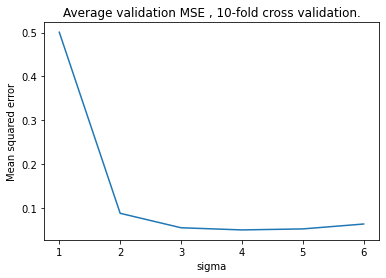

MSE on average for Polynomial kernel:  , is:  1.0890817121723486
MSE on average for Polynomial kernel:  , is:  0.7762557023009079
MSE on average for Polynomial kernel:  , is:  0.06060154555590448
MSE on average for Polynomial kernel:  , is:  0.03683197018292269


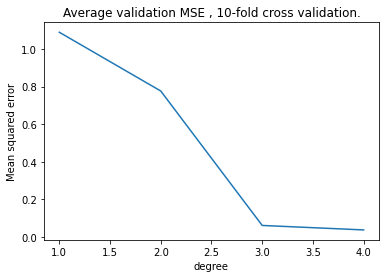

In [ ]:
Get_best_sigma()
Get_best_degree()

In [ ]:
testGaussianProcess(test_data, tot_train_data, test_labels, tot_train_labels, 'Polynomial', 4, sigma=0)

MSE for test data is:  0.04075590406574915


In [ ]:
testGaussianProcess(test_data, tot_train_data, test_labels, tot_train_labels, 'Gaussian', 1, sigma = 4)

MSE for test data is:  0.043025161668200376


In [ ]:
testGaussianProcess(test_data, tot_train_data, test_labels, tot_train_labels, 'Linear', 0, sigma=0)

MSE for test data is:  1.2275543550853012
